In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import random
import time
import scimap as sm
import anndata as ad
from functools import partial
from helperFunctions import *
from smallestEnclosingCircle import make_circle
from sklearn.mixture import GaussianMixture

Running SCIMAP  2.1.1


### Functions

git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

In [ ]:
def gmm_classify(data, 
                 n_components=2, 
                 marker_name='marker_status', 
                 component_name='component'):
    """
    Classify data using Gaussian Mixture Model (GMM).

    Parameters:
        data (DataFrame): The input data to be classified.
        n_components (int): The number of components (clusters) in the GMM. Default is 2.
        marker_name (str): The name of the column in the DataFrame to store the marker status. Default is 'marker_status', which
            is added to the name of the column being normalized. Example 'CD4_status'.
        component_name (str): The name of the column in the DataFrame to store the component assignments. Default is 'component',
            which is added to the name of the column being normalized. Example 'CD4_component'.

    Returns:
        data (pd.DataFrame): The input data with the marker status and component assignments added.

    """
    # Fit GMM to the data
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(data)
    # Predict the component (cluster) for each intensity value
    components = gmm.predict(data)
    
    # Convert to DataFrame if necessary
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data, columns=[marker_name])
    
    # Add the component assignments to the DataFrame
    data[component_name] = components

    # Extract the means of the components
    means = gmm.means_.flatten()
    print('Means: ', means)

    # Determine which component is positive (assuming higher mean indicates positive)
    positive_component = np.argmax(means)
    print('Positive Component: ', positive_component)
    negative_component = np.argmin(means)

    # Map components to positive/negative
    data[marker_name] = data[component_name].apply(lambda x: 1 if x == positive_component else 0)
    return data

def apply_gmm(file_paths, 
              markers, 
              df_together=None, 
              zscore_norm=True):
    """
    Applies Gaussian Mixture Model (GMM) classification to the given file paths and markers.

    Args:
        file_paths (list): A list of file paths.
        markers (list): A list of marker names.
        df_together (pandas.DataFrame, optional): A DataFrame to store the results. Defaults to None.

    Returns:
        pandas.DataFrame: The DataFrame containing the results of GMM classification.

    """
    for f in file_paths:
        df = pd.read_csv(f)
        # normalize
        if zscore_norm:
            df = zscore_norm(df, markers)
        df = df[markers + ['X_centroid', 'Y_centroid', 'CellID']]
        for m in markers:
            component_name = m + '_component'
            marker_name = m + '_status'
            marker_data = df[m].values.reshape(-1, 1)
            df_gmm = gmm_classify(marker_data, n_components=2, marker_name=marker_name, component_name=component_name)
            if df_together is None:
                df_together = pd.concat([df, df_gmm[marker_name]], axis=1)
            else:
                df_together = pd.concat([df_together, df_gmm[marker_name]], axis=1)
    return df_together

def zscore_norm(df, markers):
    """
    Z-score normalization of the given markers in the DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame to normalize.
        markers (list): A list of marker names.

    Returns:
        pandas.DataFrame: The normalized DataFrame.

    """
    df[markers] = df[markers].apply(lambda x: (x - x.mean()) / x.std(), axis=0)
    return df

def create_tile_rois(df, 
                     tile_size=1000, 
                     x_coord='X_centroid',
                     y_coord='Y_centroid', 
                     save=False, 
                     save_hdf5=None):
    """
    Create tile-based regions of interest (ROIs) from a dataframe of cell coordinates.

    Args:
        df (pandas.DataFrame): The dataframe containing cell coordinates.
        tile_size (int, optional): The size of each tile in pixels. Defaults to 1000.
        x_coord (str, optional): The column name for the X-coordinate of each cell. Defaults to 'X_centroid'.
        y_coord (str, optional): The column name for the Y-coordinate of each cell. Defaults to 'Y_centroid'.
        save (bool, optional): Whether to save the ROIs as individual files. Defaults to False.
        save_hdf5 (str, optional): Path to an HDF5 file to save grid dataframes for future use. Defaults to None.

    Returns:
        dict: A dictionary containing individual dataframes for each tile, grouped by grid indices.
    """

    # Calculate the grid indices for each cell
    df['X_grid'] = (df[x_coord] // tile_size).astype(int)
    df['Y_grid'] = (df[y_coord] // tile_size).astype(int)

    # Group the cells by grid indices
    grid_groups = df.groupby(['X_grid', 'Y_grid'])

    # Create a dictionary to store the individual grid dataframes
    grid_dataframes = {}

    # Iterate over the grid groups and create individual dataframes
    for (x, y), group in grid_groups:
        if len(group) > 0:  # Check if there are points in the grid
            grid_dataframes[(x, y)] = group.drop(['X_grid', 'Y_grid'], axis=1)
    if save:
        if save:
            if not save_hdf5 or not save_hdf5.endswith('.hdf5'):
                raise ValueError("Invalid save_hdf5 path. Path must be a valid string ending in '.hdf5'.")
            # Save each dataframe to the HDF5 file
            with pd.HDFStore(save_hdf5, 'w') as store:
                for (x, y), df in grid_dataframes.items():
                    # Use a key format that identifies each dataframe uniquely
                    key = f'grid_{x}_{y}'
                    store.put(key, df)
    return grid_dataframes

def load_tile_rois(hdf5_path):
    """
    Load tile ROIs from an HDF5 file.

    Parameters:
        hdf5_path (str): The path to the HDF5 file.

    Returns:
        loaded_grid_dataframes (dict): A dictionary containing the loaded dataframes, where 
            the keys are grid indices and the values are the corresponding dataframes.
    """

    # Initialize an empty dictionary to store the loaded dataframes
    loaded_grid_dataframes = {}

    # Open the HDF5 file for reading
    with pd.HDFStore(hdf5_path, 'r') as store:
        # Iterate over the keys in the HDF5 file
        for key in store.keys():
            # Remove the leading '/' from the key to match the format used when saving
            formatted_key = key[1:]
            # Split the key to get the grid indices
            _, x, y = formatted_key.split('_')
            # Convert the grid indices back to integers
            grid_indices = (int(x), int(y))
            # Load the dataframe and store it in the dictionary
            loaded_grid_dataframes[grid_indices] = store.get(key)
    return loaded_grid_dataframes


### Data Exploration with CRC Orion Multiplex Features
Sample used for EDA: P37_S49-CRC17<br>
- Assess distribution of IFM2 intensities (CD4, CD45, PD-L1, SMA)
- Z-score normalize the intensities and assess distribution
- Divide an image into ROIs/grids

In [2]:
# Load data containing IFM2 markers
ifm2_data = pd.read_csv('/michorlab/ecdyer/multiplex_spatial/P37_S49-CRC17_IFM2.csv')

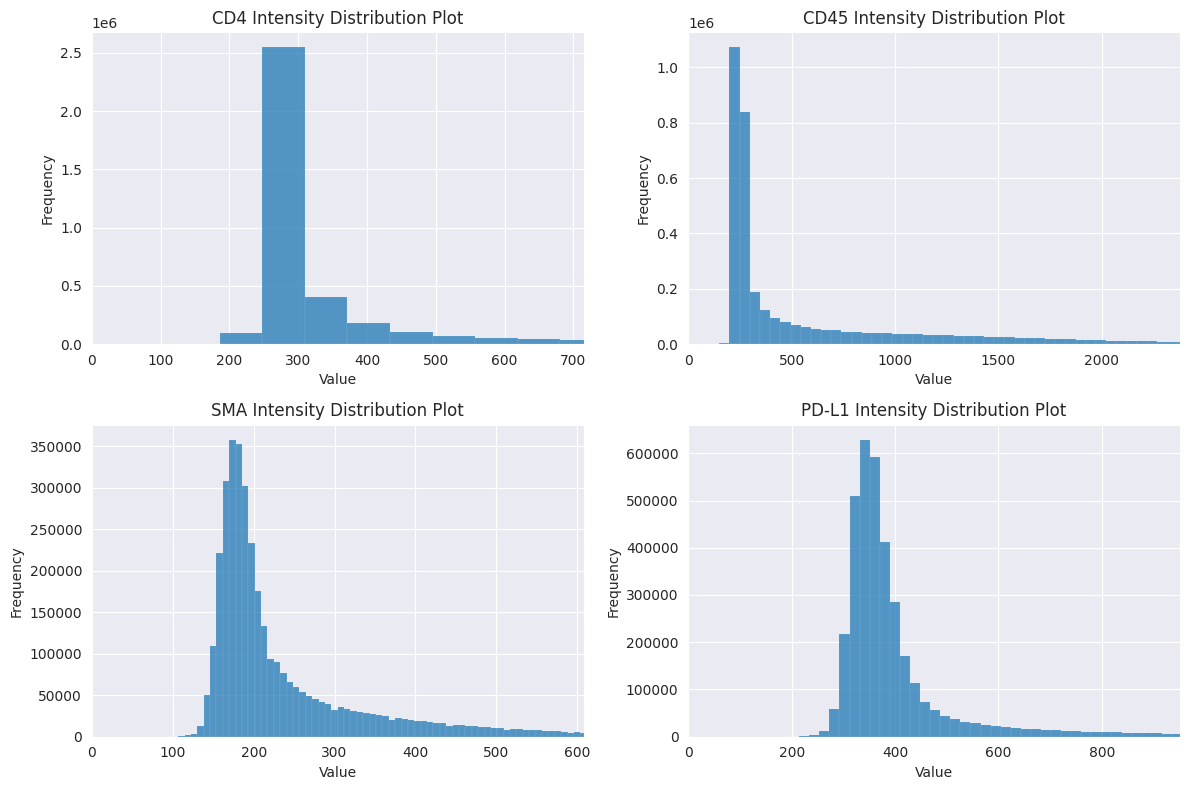

In [12]:
# Distributions without Normalization
sns.set_style("darkgrid")

titles = ['CD4 Intensity Distribution Plot',
          'CD45 Intensity Distribution Plot',
          'SMA Intensity Distribution Plot',
          'PD-L1 Intensity Distribution Plot']

columns = ['CD4', 'CD45', 'SMA', 'PD-L1']

for c in columns:
    df = ifm2_data[c]
    df = np.round(df)
    sorted_values = np.sort(df)


fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, c in enumerate(columns):
    df = ifm2_data[c]
    df = np.round(df)
    sorted_values = np.sort(df)
    
    ax = axes[i // 2, i % 2]
    sns.histplot(sorted_values, bins=500, ax=ax)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.set_title(titles[i])
    percentile_x = np.percentile(sorted_values, 97)
    ax.set_xlim(0, percentile_x)
    #ax.set_ylim(0, 350000)

plt.tight_layout()
plt.savefig('/michorlab/ecdyer/multiplex_spatial/IFM2_Markers_Distribution_CRC17.png', dpi=300)

plt.show()

In [4]:
# Z-score normalization
norm_df = ifm2_data.copy()
cols_to_norm = ['CD4', 'CD45', 'SMA', 'PD-L1']
# Apply z-score normalization only to specific columns
norm_df[cols_to_norm] = norm_df[cols_to_norm].apply(lambda x: (x - x.mean()) / x.std(), axis=0)

/tmp/ipykernel_3614002/786356963.py:26: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipykernel_3614002/786356963.py:26: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipykernel_3614002/786356963.py:26: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipykernel_3614002/786356963.py:26: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




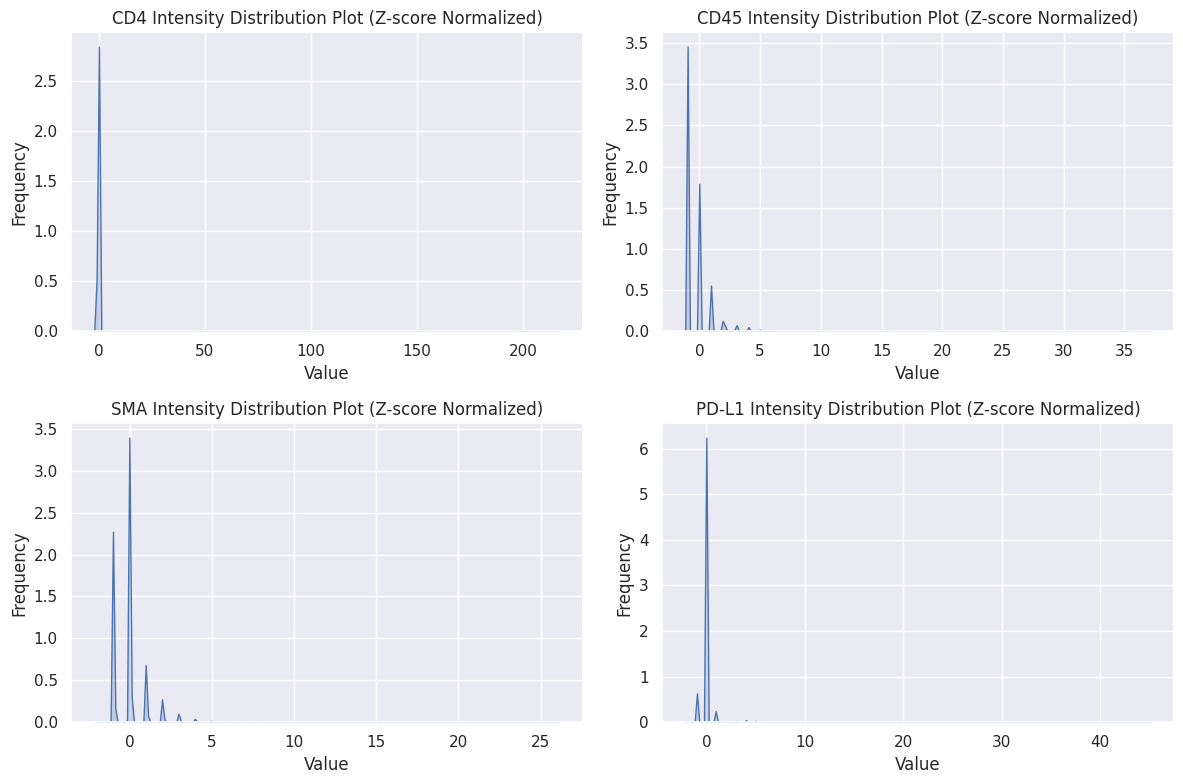

In [7]:
# Distributions with normalization
sns.set_style("darkgrid")

titles = ['CD4 Intensity Distribution Plot (Z-score Normalized)',
          'CD45 Intensity Distribution Plot (Z-score Normalized)',
          'SMA Intensity Distribution Plot (Z-score Normalized)',
          'PD-L1 Intensity Distribution Plot (Z-score Normalized)']

columns = ['CD4', 'CD45', 'SMA', 'PD-L1']

for c in columns:
    df = norm_df[c]
    df = np.round(df)
    sorted_values = np.sort(df)


fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, c in enumerate(columns):
    df = norm_df[c]
    df = np.round(df)
    sorted_values = np.sort(df)
    
    ax = axes[i // 2, i % 2]
    #sns.histplot(sorted_values, bins=500, ax=ax)
    sns.kdeplot(sorted_values, shade=True, ax=ax)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.set_title(titles[i])
    #percentile_x = np.percentile(sorted_values, 98)
    #ax.set_xlim(0, percentile_x)
    #ax.set_ylim(0, 350000)

plt.tight_layout()
plt.savefig('/michorlab/ecdyer/multiplex_spatial/IFM2_Markers_norm_Distribution_CRC17.png', dpi=300)

plt.show()

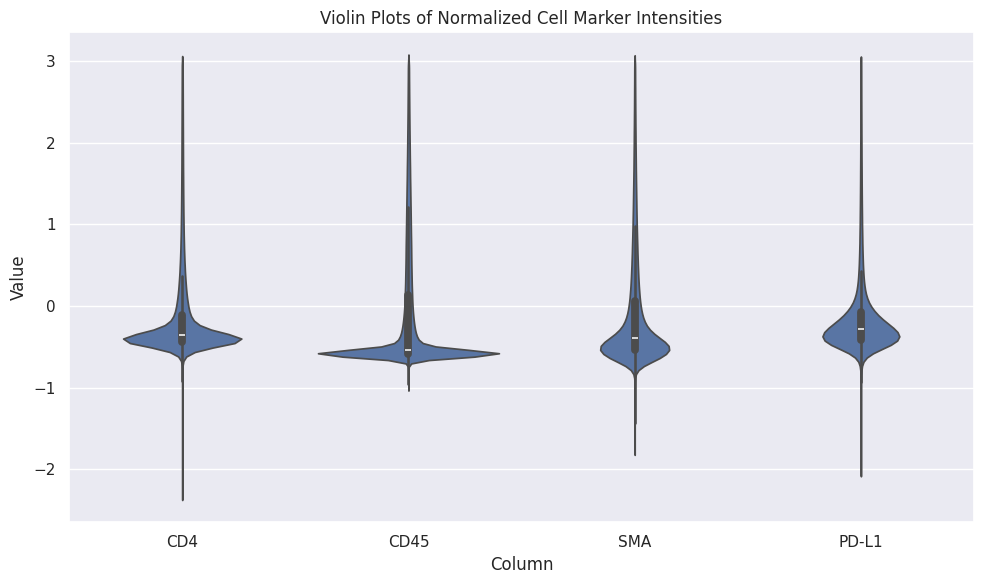

In [11]:
# Try making a violin plot

data = norm_df[['CD4', 'CD45', 'SMA', 'PD-L1']]
# Define a threshold for outliers (e.g., z-score > 3 or z-score < -3)
threshold = 3
data = data[data <= threshold]

# Reshape the data into a long format
data_long = pd.melt(data, var_name='Column', value_name='Value')

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Column', y='Value', data=data_long)
plt.title('Violin Plots of Normalized Cell Marker Intensities')

plt.tight_layout()
plt.savefig('/michorlab/ecdyer/multiplex_spatial/IFM2_Markers_violin_norm_Distribution_CRC17.png', dpi=300)
plt.show()

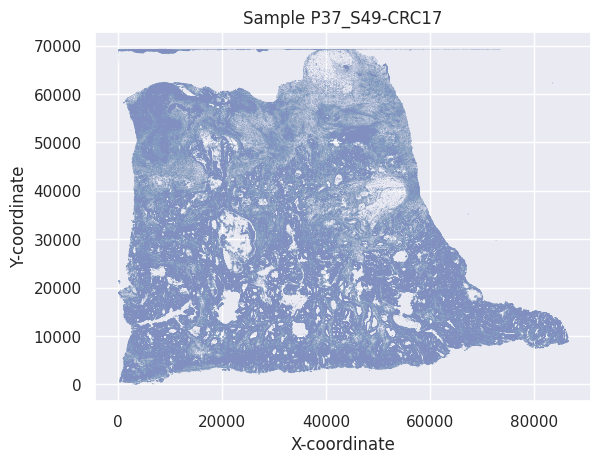

In [16]:
# Plot cell coordinates just to get an idea of the data
cell_coords = pd.read_csv('/michorlab/ecdyer/multiplex_spatial/P37_S49-CRC17_IFM2.csv')
# Remove "Unnamed" columns from the DataFrame
cell_coords = cell_coords.loc[:, ~cell_coords.columns.str.contains('^Unnamed')]

# Plotting
sns.set_theme(style='darkgrid')  # Set the aesthetic style of the plots
sns.scatterplot(data=cell_coords, x='X_centroid', y='Y_centroid', s=0.025)  # Plot points
plt.xlabel('X-coordinate')  # Optional: Set the x-axis label
plt.ylabel('Y-coordinate')  # Optional: Set the y-axis label
plt.title('Sample P37_S49-CRC17')  # Optional: Set the plot title
plt.show()

#plt.savefig('/Users/emmadyer/Desktop/michor_lab/orion_data/figures/all_points.png', dpi=300)

In [19]:
# Calculate the grid indices for each cell
cell_coords['X_grid'] = (cell_coords['X_centroid'] // 2000).astype(int)
cell_coords['Y_grid'] = (cell_coords['Y_centroid'] // 2000).astype(int)

# Group the cells by grid indices
grid_groups = cell_coords.groupby(['X_grid', 'Y_grid'])

# Create a dictionary to store the individual grid dataframes
grid_dataframes = {}

# Iterate over the grid groups and create individual dataframes
for (x, y), group in grid_groups:
    if len(group) > 0:  # Check if there are points in the grid
        grid_dataframes[(x, y)] = group.drop(['X_grid', 'Y_grid'], axis=1)

# Access the individual grid dataframes using the grid indices as keys
# For example, to access the dataframe for grid (0, 0):
grid_0_0 = grid_dataframes[(0, 0)]
print(grid_0_0)

print(grid_dataframes.keys())

              CD45         CD4          SMA       PD-L1  CellID   Y_centroid  \
284     360.482422  301.658203   150.548828  470.140625     285   402.611328   
294     328.264901  254.344371   159.377483  369.637417     295   412.493377   
301     459.466425  265.762250   130.952813  392.602541     302   421.513612   
309     458.262557  264.079909   276.554795  396.769406     310   427.107306   
317     287.866889  254.888519   197.630616  379.956739     318   434.161398   
...            ...         ...          ...         ...     ...          ...   
14696   236.119377  265.761246  1175.868512  266.871972   14697  1998.173010   
14697   361.745455  272.763636   785.483636  327.643636   14698  1995.992727   
14719  1383.612150  631.537383   709.378505  370.140187   14720  1998.163551   
14729   261.075862  281.641379   802.103448  316.062069   14730  1998.572414   
14743   251.404494  291.803371  1150.308989  339.741573   14744  1997.550562   

        X_centroid  
284    1686.455078

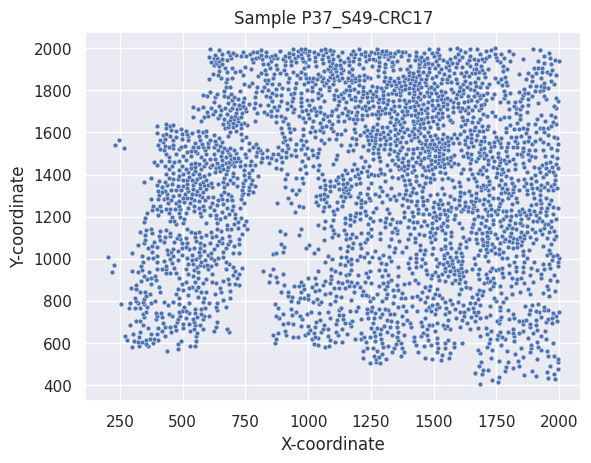

In [20]:
# Plot a single ROI

# Plotting
sns.set_theme(style='darkgrid')  # Set the aesthetic style of the plots
sns.scatterplot(data=grid_0_0, x='X_centroid', y='Y_centroid', s=12)  # Plot points
plt.xlabel('X-coordinate')  # Optional: Set the x-axis label
plt.ylabel('Y-coordinate')  # Optional: Set the y-axis label
plt.title('Sample P37_S49-CRC17')  # Optional: Set the plot title
plt.show()

### Cell Calling

Apply a Gaussian mixture model to the data to identify positive cells. 

In [6]:
# Get all .csv files in one list
data_dir = '/michorlab/labsyspharm_ORION-CRC/labsyspharm_ORION-CRC/aws_data/'
data_parent_dir = os.listdir(data_dir)

file_paths = []
for i in range(len(data_parent_dir)):
    files = os.listdir(data_dir + data_parent_dir[i])
    csv_files = [file for file in files if file.endswith('.csv')]
    for file in csv_files:
        if 'CRC15' in file:
            continue
        file_path = os.path.join(data_dir, data_parent_dir[i], file)
        file_paths.append(file_path)
#print(file_paths)

['/michorlab/labsyspharm_ORION-CRC/labsyspharm_ORION-CRC/aws_data/CRC07/P37_S35-CRC07.csv', '/michorlab/labsyspharm_ORION-CRC/labsyspharm_ORION-CRC/aws_data/CRC35/P37_S78-CRC35.csv', '/michorlab/labsyspharm_ORION-CRC/labsyspharm_ORION-CRC/aws_data/CRC14/P37_S46-CRC14.csv', '/michorlab/labsyspharm_ORION-CRC/labsyspharm_ORION-CRC/aws_data/CRC26/P37_S63-CRC26.csv', '/michorlab/labsyspharm_ORION-CRC/labsyspharm_ORION-CRC/aws_data/CRC21/P37_S58-CRC21.csv', '/michorlab/labsyspharm_ORION-CRC/labsyspharm_ORION-CRC/aws_data/CRC19/P37_S51-CRC19.csv', '/michorlab/labsyspharm_ORION-CRC/labsyspharm_ORION-CRC/aws_data/CRC13/P37_S45-CRC13.csv', '/michorlab/labsyspharm_ORION-CRC/labsyspharm_ORION-CRC/aws_data/CRC32/P37_S75-CRC32.csv', '/michorlab/labsyspharm_ORION-CRC/labsyspharm_ORION-CRC/aws_data/CRC38/P37_S81-CRC38.csv', '/michorlab/labsyspharm_ORION-CRC/labsyspharm_ORION-CRC/aws_data/CRC33_02/P37_S76_02-CRC33_02.csv', '/michorlab/labsyspharm_ORION-CRC/labsyspharm_ORION-CRC/aws_data/CRC04/P37_S32-C

In [14]:
markers = ['CD45', 'CD4', 'SMA', 'PD-L1']
file_paths = ['/michorlab/labsyspharm_ORION-CRC/labsyspharm_ORION-CRC/aws_data/CRC17/P37_S49-CRC17.csv']
df_together = None

# Apply GMM classification
df_gmm = apply_gmm(file_paths, markers, df_together)

Means:  [-0.57940745  0.64216999]
Positive Component:  1
Means:  [-0.37699993  1.01737689]
Positive Component:  1
Means:  [ 0.95666904 -0.45425902]
Positive Component:  0
Means:  [-0.29504734  1.48394847]
Positive Component:  1


In [15]:
print(df_gmm.head())

       CD45       CD4       SMA     PD-L1    X_centroid  Y_centroid  CellID  \
0  0.065671 -0.399784 -0.721079 -0.015851   3429.827925   10.779623       1   
1 -0.664576 -0.954254 -0.635298  0.710042   3792.921597   12.914469       2   
2 -0.276482  0.009577 -0.776183 -0.327701  19821.345946    7.657658       3   
3  0.480403 -0.406267 -0.746235  0.205114   3260.287879   20.074675       4   
4  0.335453 -0.391301 -0.700322 -0.002574   3291.512097   23.111895       5   

   CD45_status  CD4_status  SMA_status  PD-L1_status  
0            1           0           0             0  
1            1           1           0             1  
2            1           1           0             0  
3            1           0           0             0  
4            1           0           0             0  


In [16]:
for m in markers:
    print(df_gmm[m + '_status'].value_counts())


CD45_status
0    1947875
1    1686906
Name: count, dtype: int64
CD4_status
0    2726757
1     908024
Name: count, dtype: int64
SMA_status
0    2585483
1    1049298
Name: count, dtype: int64
PD-L1_status
0    3100654
1     534127
Name: count, dtype: int64


/tmp/ipykernel_3614002/3510278489.py:7: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/homes6/emma/miniconda3/envs/scimap/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



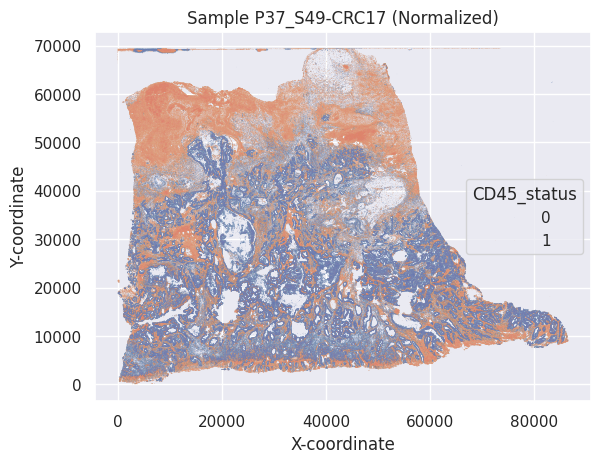

In [20]:
# Plotting
sns.set_theme(style='darkgrid')  # Set the aesthetic style of the plots
sns.scatterplot(data=df_gmm, x='X_centroid', y='Y_centroid', hue='CD45_status', s=0.025)
plt.xlabel('X-coordinate')  # Optional: Set the x-axis label
plt.ylabel('Y-coordinate')  # Optional: Set the y-axis label
plt.title('Sample P37_S49-CRC17 (Normalized)')  # Optional: Set the plot title
plt.savefig('/michorlab/ecdyer/multiplex_spatial/figures/norm_CRC17_CD45_status.png', dpi=300)
plt.show()


In [4]:
ifm2_data = pd.read_csv('/michorlab/ecdyer/multiplex_spatial/P37_S49-CRC17_IFM2.csv')